In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")

/tmp/ipykernel_15983/2370551333.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")


# Choise of unit = gram per International Dollar

In [4]:
# We are interested to work with this unit. One reason is, this is the only normalized unit of the bunch
# The value_counts() when filtered with this unit, shows just one item for the columns Item and Element.\
# Therefore no other factors
df = df[df["Unit"] == "g/Int$"]

# Continent-wise Descriptive statistics

In [5]:
# We'll do continent-wise analysis
continents_to_filter = ['Africa', 'Asia', 'Europe', 'Northern America', 'Central America', 'South America', 'Oceania']
filtered_df = df[df['Area'].isin(continents_to_filter)]

In [6]:
# We would group by Area, and find the Area's mean Value and sd of the Value
grouped_stats = filtered_df.groupby('Area')['Value'].agg(['mean', 'std'])

In [7]:
grouped_stats["Area"] = grouped_stats.index

In [8]:
grouped_stats

,mean,std,Area
Area,,,
Africa,0.428438,0.063860,Africa
Asia,0.594688,0.065795,Asia
Central America,1.210000,0.181659,Central America
Europe,0.918750,0.049693,Europe
Northern America,1.332812,0.118872,Northern America
Oceania,0.830000,0.186496,Oceania
South America,1.707812,0.613976,South America


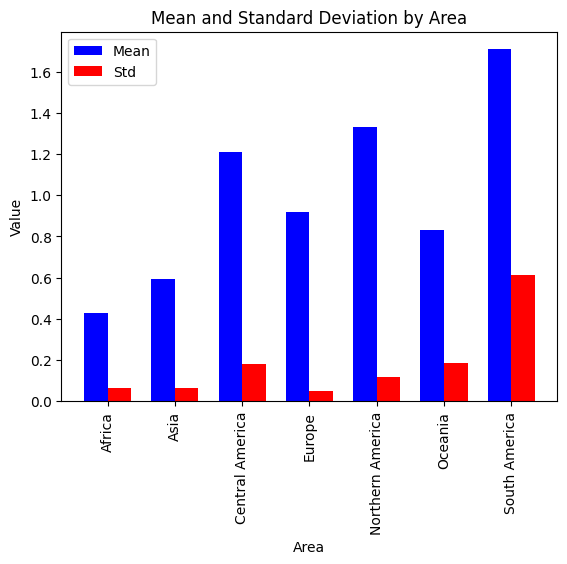

In [10]:
import matplotlib.pyplot as plt
df = grouped_stats

# Plotting grouped bar chart
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = range(len(df))

# Plotting bars for mean
bars1 = ax.bar(x, df['mean'], width=bar_width, label='Mean', color='b')

# Plotting bars for standard deviation
bars2 = ax.bar([p + bar_width for p in x], df['std'], width=bar_width, label='Std', color='r')

# Labeling the x-axis ticks with area names
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(df['Area'], rotation=90)

# Adding labels, title, and legend
ax.set_xlabel('Area')
ax.set_ylabel('Value')
ax.set_title('Mean and Standard Deviation by Area')
ax.legend()

# Show the plot
plt.show()


# Trend analysis of 7 regions (1990-2021)

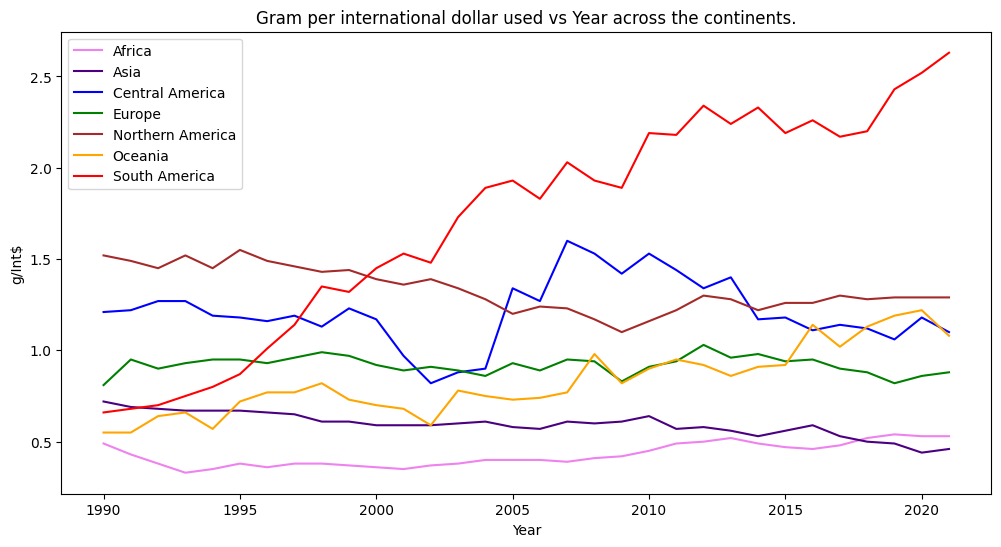

In [11]:
import matplotlib.pyplot as plt
groupedseries = filtered_df.groupby('Area')
listofdfs = [group for _, group in groupedseries]
colors = ['violet','indigo','blue','green','brown','orange','red']
plt.figure(figsize=[12,6])
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp['Area'].unique()[0]
    plt.plot(
        temp['Year'],
        temp['Value'],
        marker = None,
        linestyle = '-',
        color = colors[i],
        label =label
    )
plt.xlabel('Year')
plt.ylabel('g/Int$')
plt.title('Gram per international dollar used vs Year across the continents.')
plt.legend()
plt.show()

# Method 1: Exploring the time-series

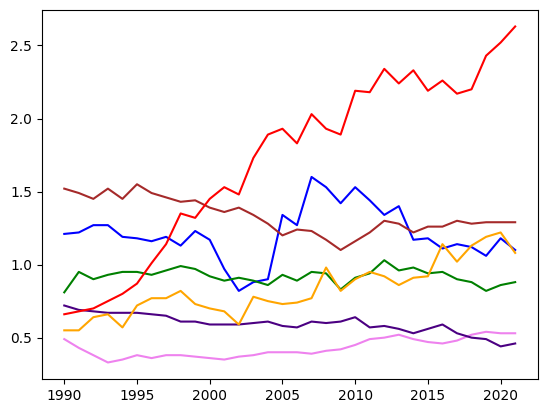

In [12]:
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp["Area"].unique()[0]
    plt.plot(
        temp['Year'],
        temp['Value'],
        marker = None,
        linestyle = '-',
        color = colors[i],
        label =label
    )

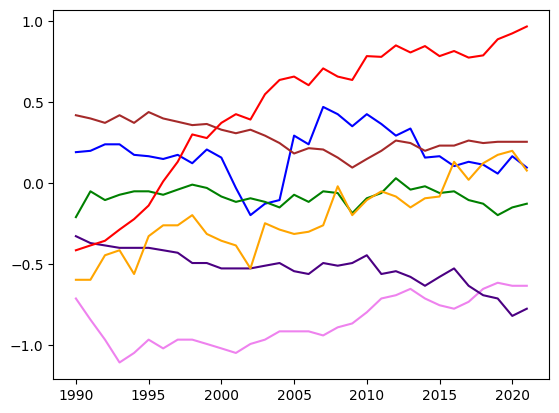

In [13]:
import numpy as np
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp["Area"].unique()[0]
    temp['Value'] = np.log(temp['Value'])
    plt.plot(
        temp['Year'],
        temp['Value'],
        marker = None,
        linestyle = '-',
        color = colors[i],
        label =label
    )

In [14]:
# When the time series is harder to judge just by looking at the plot, we should move
# on to the next step

# Method 2: ACF plot and PACF plot

p-value: 0.06040508679091213


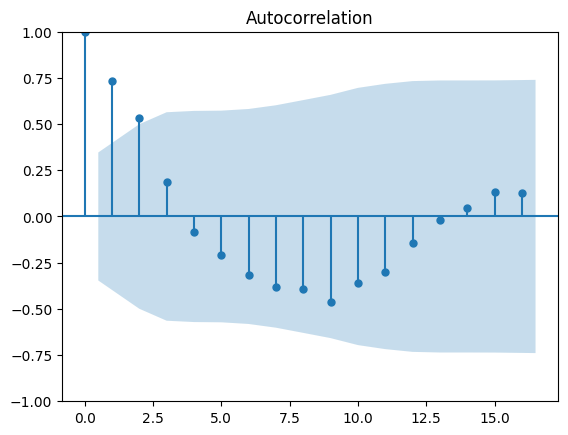

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
temp = listofdfs[2]
acf_original = plot_acf(temp["Value"])
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(temp["Value"])
print(f'p-value: {adf_test[1]}')

# Method 3: ADF test

In [16]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(temp["Value"])
print(f'p-value: {adf_test[1]}')

p-value: 0.06040508679091213


# Transform to stationary: differencing

In [17]:
temp["Value"] = temp["Value"].diff().dropna()
temp["Value"] = temp["Value"].dropna()

In [18]:
temp = temp.iloc[1:]
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(temp["Value"])
print(f'p-value: {adf_test[1]}')

p-value: 2.6291566281205717e-07


In [42]:
temp["Value"]

101958    0.008230
101959    0.040166
101960    0.000000
101961   -0.065064
101962   -0.008439
101963   -0.017094
101964    0.025533
101965   -0.051736
101966    0.084797
101967   -0.050010
101968   -0.187463
101969   -0.167992
101970    0.070618
101971    0.022473
101972    0.398030
101973   -0.053653
101974    0.230987
101975   -0.044736
101976   -0.074611
101977    0.074611
101978   -0.060625
101979   -0.071973
101980    0.043803
101981   -0.179468
101982    0.008511
101983   -0.061154
101984    0.026668
101985   -0.017700
101986   -0.055060
101987    0.107246
101988   -0.070204
Name: Value, dtype: float64

In [43]:
# resource for understanding acf and pacf: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

In [44]:
# Step 1: Check for stationarity of time series
#  Method 1: Time series plot
#  Method 2: ACF plot and PACF plot
#  Method 3: ADF test
# Step 2: Determine ARIMA model params p and q
# Step 3: Fit the ARIMA model
# Step 4: Make time series predictions
# (Optional): Auto-fit ARIMA model
# Step 5: Evaluate model predictions

/tmp/ipykernel_5944/722257608.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
/tmp/ipykernel_5944/722257608.py:10: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Sat, 06 Jul 2024   AIC                            408.969
Time:                        22:58:33   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

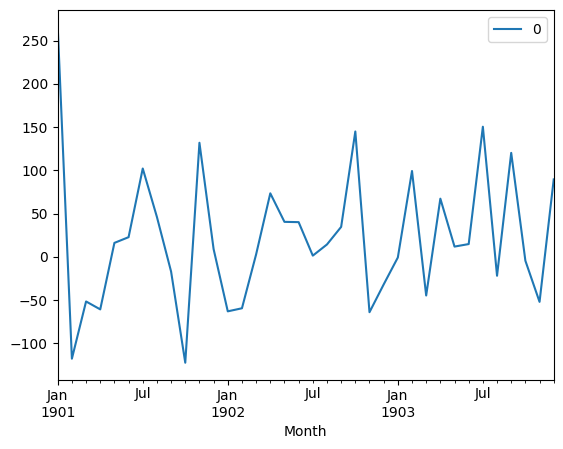

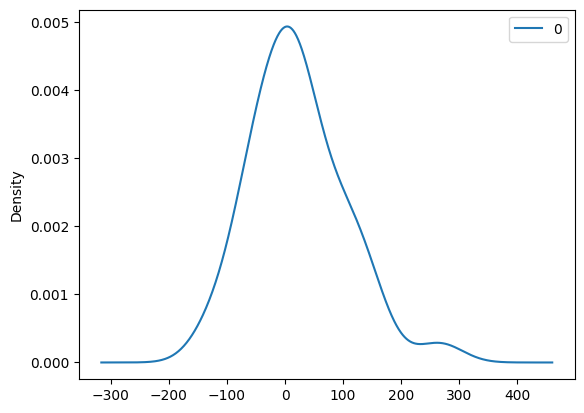

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


In [45]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series.index = series.index.to_period('M')
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# Step 0: exploring the dataset

In [19]:
df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")
df = df[df["Unit"] == "g/Int$"]
continents_to_filter = ['Africa', 'Asia', 'Europe', 'Northern America', 'Central America', 'South America', 'Oceania']
df = df[df['Area'].isin(continents_to_filter)]

/tmp/ipykernel_15983/3554862881.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")


In [20]:
df["Logvalue"] = np.log(df["Value"])

In [21]:
groupedseries = df.groupby('Area')
listofdfs = [group for _, group in groupedseries]

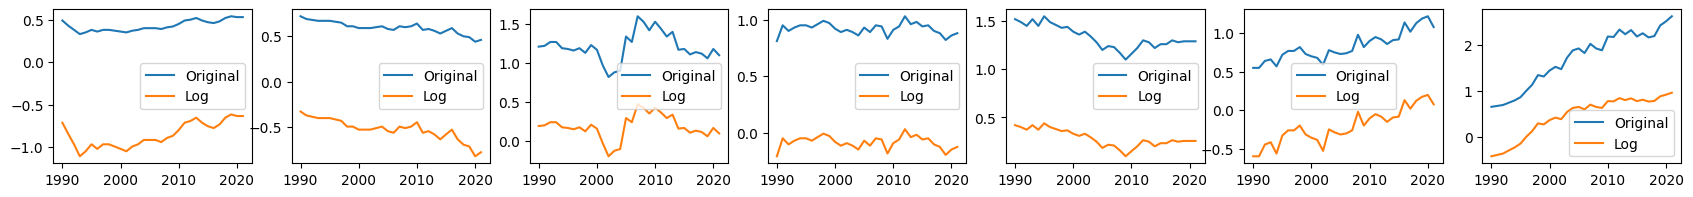

In [22]:
fig, axs = plt.subplots(1, len(listofdfs), figsize=(21,2))
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp['Area'].unique()[0]
    axs[i].plot(temp['Year'], temp['Value'], label = "Original")
    axs[i].plot(temp['Year'], temp['Logvalue'], label = "Log")
    axs[i].legend()

In [23]:
# by looking at the top figure
# from left to right: africa, asia, central america, europe, northern america, oceania, and south america
# low variance:       orgn    orgn  log              ?       ?                 ?            ?

In [24]:
orgn_stats = df.groupby('Area')['Value'].agg(['mean', 'std'])
log_stats = df.groupby('Area')['Logvalue'].agg(['mean', 'std'])

In [25]:
orgn_stats

,mean,std
Area,,
Africa,0.428438,0.063860
Asia,0.594688,0.065795
Central America,1.210000,0.181659
Europe,0.918750,0.049693
Northern America,1.332812,0.118872
Oceania,0.830000,0.186496
South America,1.707812,0.613976


In [26]:
log_stats

,mean,std
Area,,
Africa,-0.858206,0.147364
Asia,-0.525938,0.114825
Central America,0.179390,0.153822
Europe,-0.086179,0.054710
Northern America,0.283444,0.089121
Oceania,-0.210365,0.222423
South America,0.454863,0.435082


In [27]:
# by looking at the stats
# from left to right: africa, asia, central america, europe,  northern america, oceania, and south america
# low variance:       orgn    orgn  ? = log          ? = orgn ? = log           ? = orgn     ? = log

In [28]:
choosinglogvalue = [0, 0, 1, 0, 1, 0, 1]

# Step 1: check for stationarity of time-series

## Method 1: time series plot

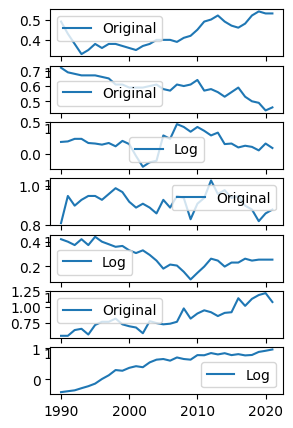

In [34]:
fig, axs = plt.subplots(len(listofdfs),1, figsize=(3,5))
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp['Area'].unique()[0]
    if choosinglogvalue[i] == 0:
        axs[i].plot(temp['Year'], temp['Value'], label = "Original")
    else:
        axs[i].plot(temp['Year'], temp['Logvalue'], label = "Log")
    

    axs[i].legend()